In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras import regularizers
import glob
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import json
import zipfile
import subprocess


In [3]:

# Step 1: Unzip the Dataset
zip_path = '/content/drive/MyDrive/Edge AI Project/set_images/training data labeled.zip'
extract_path = '/content/air_piano_dataset'

if not os.path.exists(extract_path):
    os.makedirs(extract_path)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Debug: List extracted contents
print("Extracted contents:")
result = subprocess.run(f"ls -R {extract_path}", shell=True, capture_output=True, text=True)
print(result.stdout)

# Step 2: Rename Files to Simplified Format
directory = extract_path
renamed_count = 0

for root, dirs, files in os.walk(directory):
    for filename in files:
        if "train data3" in filename and filename.endswith(".jpg"):
            old_path = os.path.join(root, filename)
            parts = filename.split(".")
            base_name = parts[0].replace(" ", "_")  # e.g., "train_data3"
            identifier = [part for part in parts if part.startswith("s") and part[1:].isdigit()]
            identifier = identifier[0] if identifier else None
            aug_part = [part for part in parts if "aug" in part]
            aug_part = aug_part[0].replace("_", "") if aug_part else "aug0"

            if not identifier:
                print(f"No identifier in {filename}, skipping...")
                continue

            new_name = f"{base_name}_{identifier}_{aug_part}.jpg"
            new_path = os.path.join(root, new_name)
            os.rename(old_path, new_path)
            print(f"Renamed: {old_path} -> {new_path}")
            renamed_count += 1

print(f"Total files renamed: {renamed_count}")

Extracted contents:
/content/air_piano_dataset:
training data labeled

/content/air_piano_dataset/training data labeled:
bounding_boxes.labels
info.labels
train data3.mp4.5psoioun.ingestion-54c4c64498-bpmm6.s1003.jpg
train data3.mp4.5psoioun.ingestion-54c4c64498-bpmm6.s1009.jpg
train data3.mp4.5psoioun.ingestion-54c4c64498-bpmm6.s1015.jpg
train data3.mp4.5psoioun.ingestion-54c4c64498-bpmm6.s1021.jpg
train data3.mp4.5psoioun.ingestion-54c4c64498-bpmm6.s1027.jpg
train data3.mp4.5psoioun.ingestion-54c4c64498-bpmm6.s1033.jpg
train data3.mp4.5psoioun.ingestion-54c4c64498-bpmm6.s1039.jpg
train data3.mp4.5psoioun.ingestion-54c4c64498-bpmm6.s1045.jpg
train data3.mp4.5psoioun.ingestion-54c4c64498-bpmm6.s1051.jpg
train data3.mp4.5psoioun.ingestion-54c4c64498-bpmm6.s1057.jpg
train data3.mp4.5psoioun.ingestion-54c4c64498-bpmm6.s1063.jpg
train data3.mp4.5psoioun.ingestion-54c4c64498-bpmm6.s1069.jpg
train data3.mp4.5psoioun.ingestion-54c4c64498-bpmm6.s1075.jpg
train data3.mp4.5psoioun.ingestion-54c4

In [4]:
# Step 3: Load Bounding Boxes
annotation_file = '/content/drive/MyDrive/Edge AI Project/bounding_boxes.labels'

print(f"Image directory exists: {os.path.exists(directory)}")
print(f"Annotation file exists: {os.path.exists(annotation_file)}")

with open(annotation_file, 'r') as f:
    annotations_data = json.load(f)

bounding_boxes = annotations_data.get('boundingBoxes', {})

# Create a set of identifiers with bounding boxes
bbox_identifiers = set()
for image_name in bounding_boxes.keys():
    parts = image_name.split(".")
    for part in parts:
        if part.startswith("s") and part[1:].isdigit():
            bbox_identifiers.add(part)


Image directory exists: True
Annotation file exists: True


In [5]:
# Step 3: Load Bounding Boxes
annotation_file = '/content/drive/MyDrive/Edge AI Project/bounding_boxes.labels'

print(f"Image directory exists: {os.path.exists(directory)}")
print(f"Annotation file exists: {os.path.exists(annotation_file)}")

with open(annotation_file, 'r') as f:
    annotations_data = json.load(f)

bounding_boxes = annotations_data.get('boundingBoxes', {})

# Create a mapping from identifier to original name and bounding boxes
id_to_bboxes = {}
for original_name, bboxes in bounding_boxes.items():
    parts = original_name.split(".")
    for part in parts:
        if part.startswith("s") and part[1:].isdigit():
            identifier = part  # e.g., "s115"
            id_to_bboxes[identifier] = bboxes
            break
    else:
        print(f"No identifier found in {original_name}, skipping...")

# Debug: Check number of bounding boxes per image
bbox_counts = {identifier: len(bboxes) for identifier, bboxes in id_to_bboxes.items()}
print("Number of bounding boxes per image (sample):", dict(list(bbox_counts.items())[:5]))

# Step 4: Process Images and Labels (Positive and Negative)
image_files = glob.glob(f"{directory}/**/train_data3_*.jpg", recursive=True)
print(f"Total images found: {len(image_files)}")

images = []
boxes = []
labels = []

for img_path in image_files:
    filename = os.path.basename(img_path)
    parts = filename.split("_")
    if len(parts) < 4:
        print(f"Invalid filename format: {filename}, skipping...")
        continue
    identifier = parts[2]  # e.g., "s115"

    # Load image as grayscale
    img = cv2.imread(img_path, 0)
    if img is None:
        print(f"Failed to load image: {img_path}, skipping...")
        continue

    original_height, original_width = img.shape
    img = cv2.resize(img, (48, 48))
    img = img.astype(np.float32) / 255.0  # Normalize to [0,1]
    img = np.expand_dims(img, axis=-1)    # Shape: (96, 96, 1)
    images.append(img)

    # Look up bounding boxes using the identifier
    boxes_list = id_to_bboxes.get(identifier, [])

    if len(boxes_list) >= 1:  # Positive sample if there's at least one box
        bbox = boxes_list[0]
        x = bbox.get('x', 0)
        y = bbox.get('y', 0)
        width = bbox.get('width', 0)
        height = bbox.get('height', 0)

        scale_x = 48 / original_width
        scale_y = 48 / original_height
        scaled_x_min = x * scale_x
        scaled_y_min = y * scale_y
        scaled_x_max = (x + width) * scale_x
        scaled_y_max = (y + height) * scale_y

        box = [scaled_x_min, scaled_y_min, scaled_x_max, scaled_y_max]
        boxes.append(box)
        labels.append(1)  # "index finger" (positive)
    else:
        boxes.append([0, 0, 0, 0])
        labels.append(0)  # "no finger" (negative)

# Convert to arrays
images = np.array(images)
boxes = np.array(boxes)
labels = np.array(labels)

if len(images) == 0:
    raise ValueError("No images found. Check your dataset and bounding_boxes.labels.")

# Train/validation split
X_train, X_val, y_train_boxes, y_val_boxes, y_train_labels, y_val_labels = train_test_split(
    images, boxes, labels, test_size=0.2, random_state=42
)

print("Training label distribution:", np.bincount(y_train_labels))
print("Validation label distribution:", np.bincount(y_val_labels))


Image directory exists: True
Annotation file exists: True
Number of bounding boxes per image (sample): {'s3451': 0, 's3445': 0, 's3439': 0, 's3433': 0, 's3427': 0}
Total images found: 563
Training label distribution: [216 234]
Validation label distribution: [50 63]


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def build_model(input_shape=(48, 48, 1)):
    model = models.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [7]:
model = build_model()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train_labels,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val_labels),
    callbacks=[early_stopping]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.5173 - loss: 0.7935 - val_accuracy: 0.5575 - val_loss: 0.7396
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.5245 - loss: 0.7313 - val_accuracy: 0.5575 - val_loss: 0.7110
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.5389 - loss: 0.7091 - val_accuracy: 0.6460 - val_loss: 0.6972
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5355 - loss: 0.6959 - val_accuracy: 0.6460 - val_loss: 0.6784
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5547 - loss: 0.6855 - val_accuracy: 0.6460 - val_loss: 0.6632
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5925 - loss: 0.6748 - val_accuracy: 0.6814 - val_loss: 0.6546
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6078 - loss: 0.6615 - val_accuracy: 0.6195 - val_loss: 0.6538
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5602 - loss: 0.6847 - val_accuracy: 0.6195 - 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


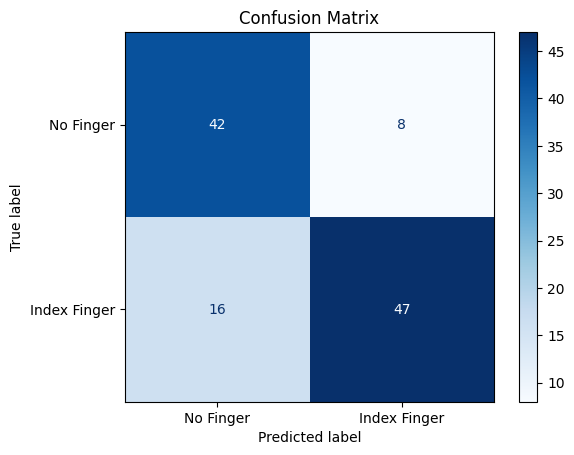

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict
y_pred = model.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_val_labels, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Finger", "Index Finger"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


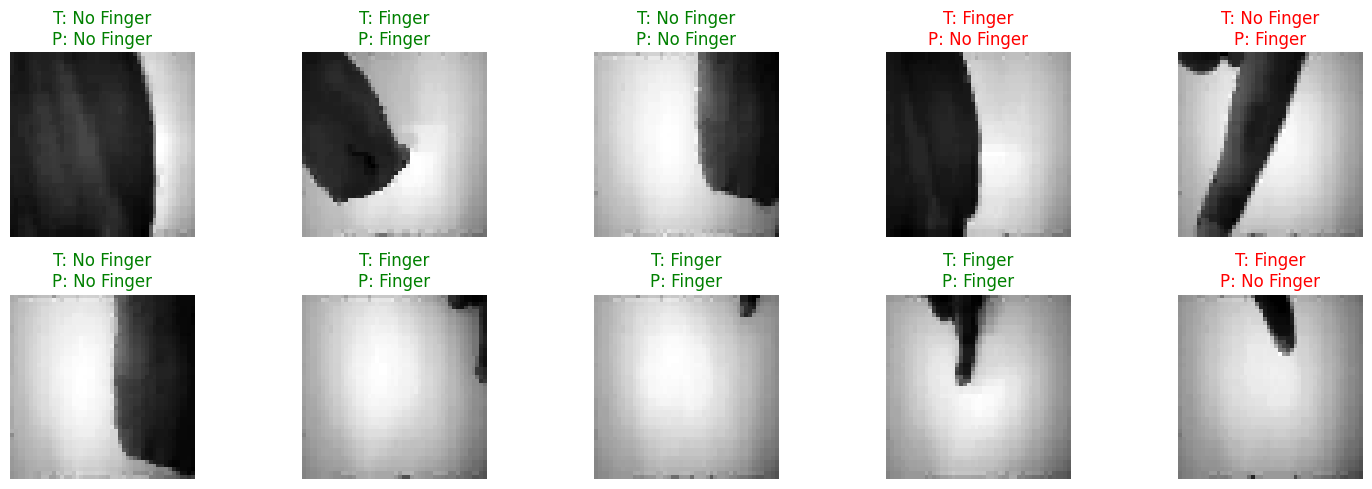

In [9]:
import matplotlib.pyplot as plt

# Predict
y_pred_probs = model.predict(X_val)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

# Show some predictions
num_samples = 10
plt.figure(figsize=(15, 5))

for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    img = X_val[i].squeeze()  # (96, 96)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    true_label = "Finger" if y_val_labels[i] else "No Finger"
    pred_label = "Finger" if y_pred_classes[i] else "No Finger"
    color = 'green' if y_pred_classes[i] == y_val_labels[i] else 'red'
    plt.title(f"T: {true_label}\nP: {pred_label}", color=color)
plt.tight_layout()
plt.show()


In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save
with open("model_float32.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmp48kkejfv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132882322662864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132882322669200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132882322669392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132882322669008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132882290983376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132882290984528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132882322663056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132882290984912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132882290985296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132882290986832: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [11]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
        yield [tf.cast(input_value, tf.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_int_model = converter.convert()
with open("model_int8.tflite", "wb") as f:
    f.write(tflite_int_model)


Saved artifact at '/tmp/tmp8v3hi8ew'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132882322662864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132882322669200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132882322669392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132882322669008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132882290983376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132882290984528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132882322663056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132882290984912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132882290985296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132882290986832: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [12]:
loss, acc = model.evaluate(X_val, y_val_labels, verbose=0)
print(f"Original model accuracy: {acc:.4f}")


Original model accuracy: 0.7876


In [13]:
import os
import numpy as np
import tensorflow as tf

def evaluate_tflite_model(tflite_path, X, y_true):
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()

    input_details  = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    correct = 0
    for i in range(len(X)):
        # Prepare input
        shape = input_details['shape']
        input_dtype = input_details['dtype']
        input_data = X[i:i+1].astype(np.float32)

        # Quantize if needed
        if input_dtype == np.uint8:
            scale, zero_point = input_details['quantization']
            input_data = (input_data / scale + zero_point).round().astype(np.uint8)

        input_data = input_data.reshape(shape)
        interpreter.set_tensor(input_details['index'], input_data)
        interpreter.invoke()

        # Get output
        output = interpreter.get_tensor(output_details['index'])
        # Dequantize if needed
        if output_details['dtype'] == np.uint8:
            o_scale, o_zero_point = output_details['quantization']
            output = (output.astype(np.float32) - o_zero_point) * o_scale

        pred = int(output[0][0] > 0.5)
        if pred == int(y_true[i]):
            correct += 1

    accuracy = correct / len(X)
    print(f"{os.path.basename(tflite_path)} accuracy: {accuracy:.4f}")
    return accuracy

# Usage
evaluate_tflite_model("model_float32.tflite", X_val, y_val_labels)
evaluate_tflite_model("model_int8.tflite", X_val, y_val_labels)

# Model file sizes
for fname in ["model_float32.tflite", "model_int8.tflite"]:
    size_kb = os.path.getsize(fname) / 1024
    print(f"{fname} size: {size_kb:.2f} KB")

model_float32.tflite accuracy: 0.7876
model_int8.tflite accuracy: 0.7876
model_float32.tflite size: 351.38 KB
model_int8.tflite size: 96.38 KB


In [14]:
import time
import numpy as np
import tensorflow as tf

def measure_inference_time(tflite_path, n_runs=100):
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_data = X_val[0:1]
    if input_details[0]['dtype'] == np.uint8:
        scale, zero_point = input_details[0]['quantization']
        input_data = input_data / scale + zero_point
        input_data = np.clip(input_data, 0, 255).astype(np.uint8)

    # Warm-up
    for _ in range(5):
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()

    # Measure
    times = []
    for _ in range(n_runs):
        start = time.time()
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        end = time.time()
        times.append((end - start) * 1000)  # in milliseconds

    avg_time = np.mean(times)
    print(f"{os.path.basename(tflite_path)} avg inference time: {avg_time:.2f} ms")

measure_inference_time("model_float32.tflite")
measure_inference_time("model_int8.tflite")

model_float32.tflite avg inference time: 0.18 ms
model_int8.tflite avg inference time: 0.30 ms
